In [43]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [44]:
words = open('data/names.txt', 'r').read().splitlines()

In [45]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [46]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [47]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden)) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden) * 0.01
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [48]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 1000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/  20000: 3.3048
   1000/  20000: 2.2485
   2000/  20000: 2.3604
   3000/  20000: 2.3711
   4000/  20000: 2.2938
   5000/  20000: 2.1345
   6000/  20000: 1.9932
   7000/  20000: 2.2950
   8000/  20000: 2.0031
   9000/  20000: 2.1487
  10000/  20000: 2.3771
  11000/  20000: 2.4109
  12000/  20000: 2.1666
  13000/  20000: 2.2969
  14000/  20000: 2.4852
  15000/  20000: 1.9879
  16000/  20000: 2.5957
  17000/  20000: 2.2874
  18000/  20000: 2.5150
  19000/  20000: 2.2585


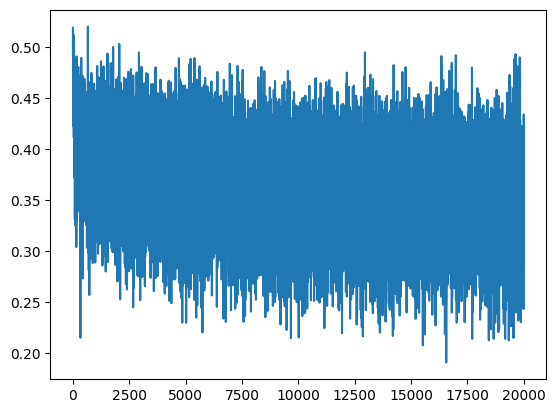

In [49]:
plt.plot(lossi)

In [50]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [51]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.210513114929199
val 2.2355868816375732


## Summary + Pytorchifying 

In [52]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [53]:
# same optimization as last time
max_steps = 20000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 10:
    break # AFTER_DEBUG: would take out obviously to run full optimization
      
layers[2].out.shape

      0/  20000: 3.3162


torch.Size([32, 100])

layer 2 (      Tanh): mean -0.00, std 0.62, saturated: 3.28%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 3.22%
layer 8 (      Tanh): mean -0.00, std 0.63, saturated: 2.69%
layer 11 (      Tanh): mean -0.00, std 0.63, saturated: 2.69%
layer 14 (      Tanh): mean -0.00, std 0.63, saturated: 2.50%


Text(0.5, 1.0, 'activation distribution')

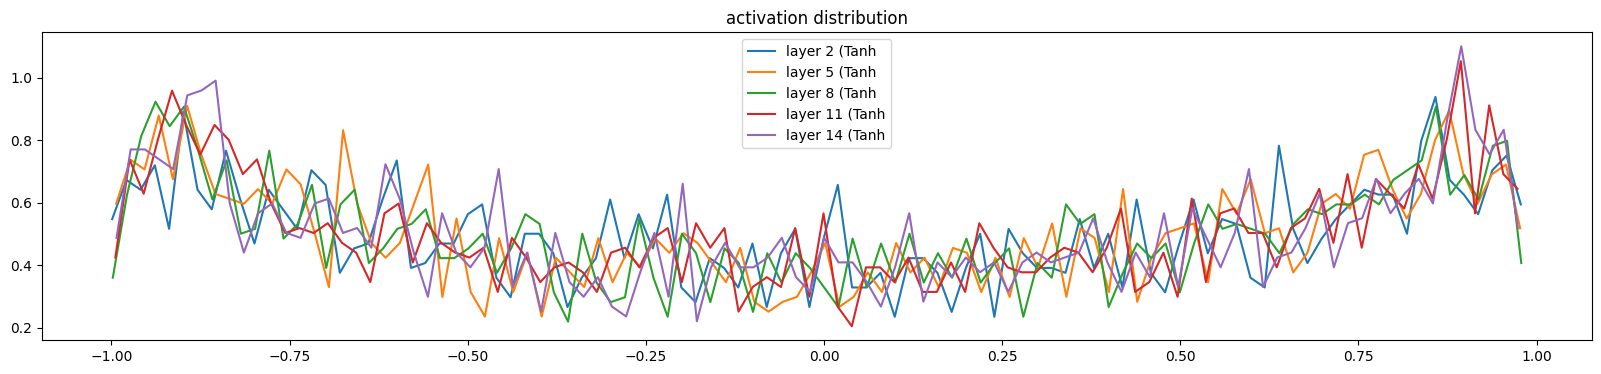

In [54]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [55]:
torch.histogram(layers[2].out.grad, density=True)

torch.return_types.histogram(
hist=tensor([  3.6521,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   3.6520,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   3.6521,   3.6521,   0.0000,
          3.6521,   0.0000,   0.0000,   7.3041,  10.9562,   0.0000,   3.6521,
         14.6082,  21.9124,  21.9123,  18.2603,  25.5644,  43.8248,  51.1289,
         65.7370,  36.5206,  65.7370,  73.0413,  87.6495, 113.2140,  91.3011,
        153.3867, 138.7784, 211.8185, 277.5569, 200.8635, 328.6857, 277.5561,
        328.6857, 445.5506, 540.5054, 489.3766, 555.1122, 690.2401, 668.3259,
        639.1111, 595.2848, 540.5054, 456.5067, 449.2039, 449.2039, 284.8602,
        350.5981, 230.0794, 237.3841, 171.6465, 160.6908, 178.9506, 135.1264,
         58.4329, 113.2138, 124.1702,  73.0412,  58.4329,  32.8685,  51.1288,
         43.8247,  18.2603,  

In [56]:
layers[2].out.grad

tensor([[ 7.3343e-04,  6.5095e-04, -3.9956e-04,  ...,  3.7030e-04,
          3.7534e-04, -3.7514e-04],
        [-3.0706e-03, -4.7729e-04, -4.2936e-04,  ...,  3.3343e-04,
         -1.2758e-03,  1.4558e-03],
        [ 5.5401e-06,  8.2863e-04,  3.7838e-04,  ...,  5.3256e-04,
          1.5365e-03,  8.4434e-04],
        ...,
        [ 1.1928e-03,  1.9809e-05, -8.0976e-04,  ..., -1.1979e-03,
         -1.4735e-05, -4.7246e-04],
        [ 6.8911e-04, -1.4150e-04, -8.6777e-04,  ..., -8.6726e-04,
         -1.5641e-03,  1.0511e-04],
        [ 2.1389e-04, -1.5311e-04,  6.8247e-04,  ..., -6.6068e-04,
          9.8945e-04, -8.9227e-04]])

layer 2 (      Tanh): mean -0.000000, std 8.062972e-04
layer 5 (      Tanh): mean -0.000000, std 6.575415e-04
layer 8 (      Tanh): mean -0.000000, std 5.983046e-04
layer 11 (      Tanh): mean +0.000000, std 5.314857e-04
layer 14 (      Tanh): mean +0.000000, std 4.536646e-04


Text(0.5, 1.0, 'gradient distribution')

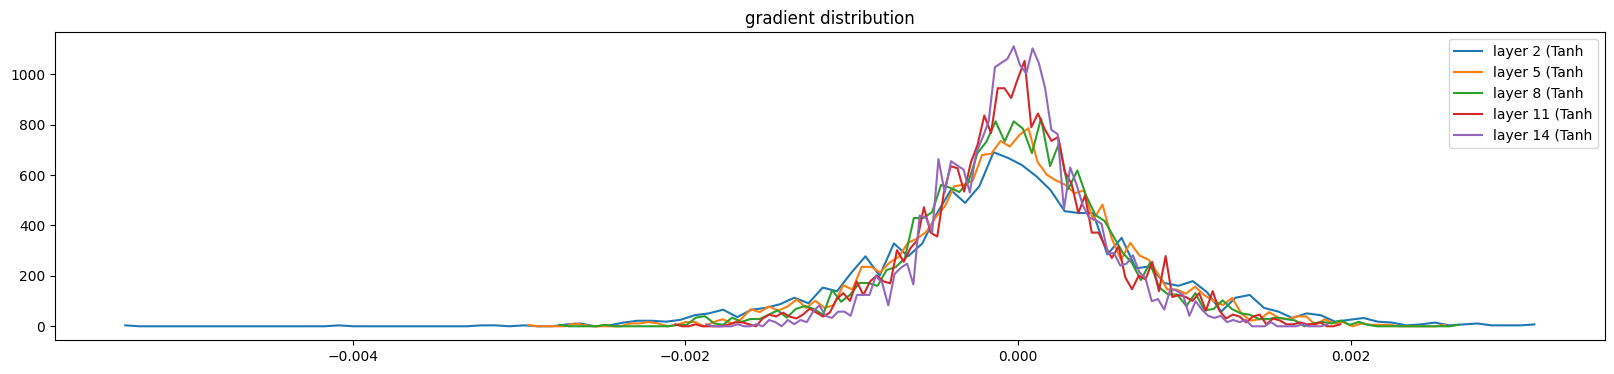

In [57]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 2.600975e-03 | grad:data ratio 2.608895e-03
weight  (30, 100) | mean +0.000006 | std 3.044179e-03 | grad:data ratio 1.649458e-02
weight (100, 100) | mean +0.000038 | std 2.834180e-03 | grad:data ratio 2.840095e-02
weight (100, 100) | mean -0.000007 | std 2.358009e-03 | grad:data ratio 2.353915e-02
weight (100, 100) | mean +0.000001 | std 2.169037e-03 | grad:data ratio 2.188837e-02
weight (100, 100) | mean +0.000009 | std 1.984077e-03 | grad:data ratio 1.978496e-02
weight  (100, 27) | mean -0.000003 | std 3.329238e-03 | grad:data ratio 3.333459e-02


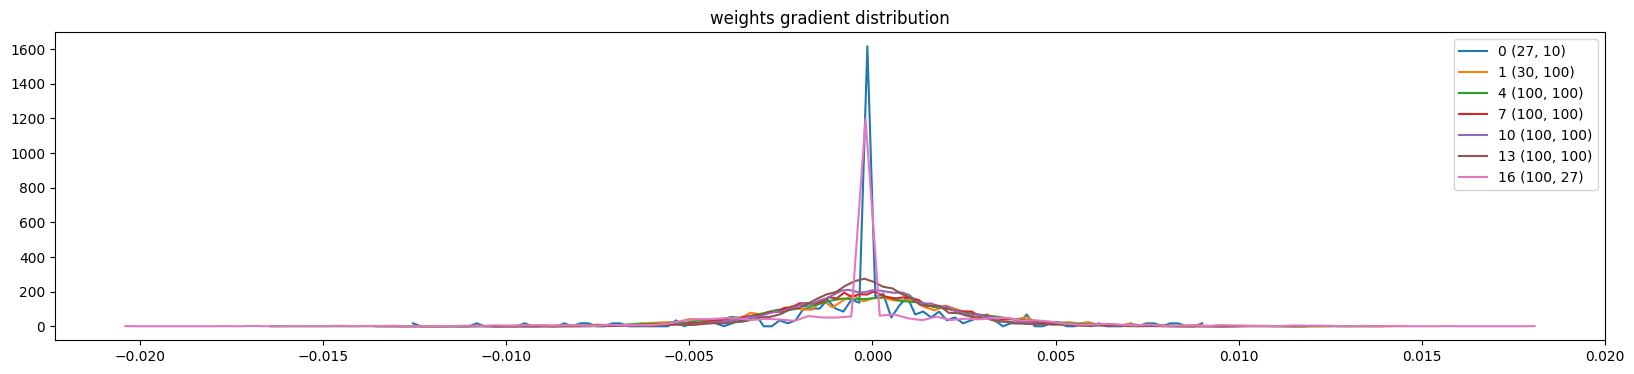

In [58]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [75]:
for i,p in enumerate(parameters):
  

0 torch.Size([27, 10])
1 torch.Size([30, 100])
2 torch.Size([100])
3 torch.Size([100])
4 torch.Size([100, 100])
5 torch.Size([100])
6 torch.Size([100])
7 torch.Size([100, 100])
8 torch.Size([100])
9 torch.Size([100])
10 torch.Size([100, 100])
11 torch.Size([100])
12 torch.Size([100])
13 torch.Size([100, 100])
14 torch.Size([100])
15 torch.Size([100])
16 torch.Size([100, 27])
17 torch.Size([27])
18 torch.Size([27])


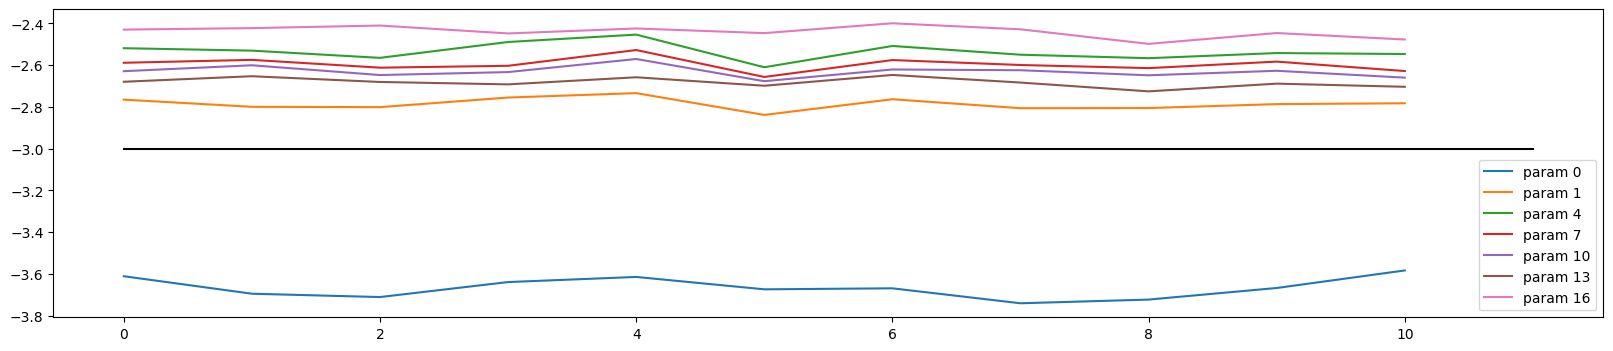

In [59]:
# visualize histograms
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [60]:
parameters[0].grad

tensor([[-7.9169e-03, -1.0673e-02, -4.2775e-05,  1.3754e-03, -1.2543e-02,
          8.4704e-03, -6.7202e-03,  7.6892e-03,  9.2216e-03,  4.2993e-03],
        [ 4.9269e-03,  1.4841e-03,  3.2986e-03, -3.4097e-03,  1.0012e-03,
         -4.8082e-03,  1.0924e-03,  7.8157e-03, -3.2438e-03, -9.4939e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-1.6728e-04,  1.7261e-04, -4.2407e-03, -1.2911e-04,  9.2185e-04,
         -8.3253e-04,  5.5404e-04, -1.1441e-03, -2.1310e-03,  4.2306e-03],
        [ 3.0650e-03,  5.6097e-06,  8.8131e-04,  2.4328e-03,  6.3503e-03,
         -4.5718e-03, -4.0778e-04, -5.2127e-03, -1.1118e-03,  2.2452e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+0

In [61]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 3.2525007724761963
val 3.252561569213867


In [62]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

olaozdfblprgkaeixdjvofpzuxcrqxihgnqevotwsgiiovvcwnisififkgwkmcumpbgjtl.
s.
byrfdobnocgdcktrcntzmlmcmcrvsrddtpiodtbgrkgijrrsbxsm.
kdyiktmpoqihxcyapa.
imjdihqgfymggg.
ocgenhhbmzwaqgwbauacntdercrldsmumlh.
mymqqpioujlppobwpjodnozlvrscoanuvssjivtsgzbqravdfcaiabnjlkgsypmsvxpgmlveqonsnpaykhewjduffzfsrddbicnpnlvnmyzyyf.
dmvjsmcovwvwyen.
omitasleyacobbkgtoprqjprhuddvzbhfnwmszjropmfjjzflgzsgrucnv.
geaihaaaybrpxpcfxgqorasi.
clpdyrafauqoljsktqqkhntnh.
uyae.
eht.
.
xsgrfnpxmuhjjyeki.
igamxkchwqchp.
vxkvfqjhweoettyjtlvwwnrrhrelqmu.
fkmzwcpnfdkozvewuvsvotxwwyuavskehf.
awwstrgecclyhnhbwwvq.
ucbwotffiszehnsdodvpgixuhooxvfjyxnoyvublqkfron.
